# Рейтинги на ревюта за филми от IMDB

<strong>Около 50000 филмови рейтинги от потребители на платформата</strong>

![](https://media1.tenor.com/images/54451401d52c0dd2fe9ee5752857d53c/tenor.gif?itemid=4452103)

In [138]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
from wordcloud import WordCloud
from IPython.display import display
from collections import Counter
from nltk.corpus import stopwords
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Activation, Embedding
from keras.optimizers import SGD, Adam

Зареждаме данните

In [2]:
train = pd.DataFrame.from_csv('data/imdb/labeledTrainData.tsv.zip', sep='\t')
test = pd.DataFrame.from_csv('data/imdb/testData.tsv.zip', sep='\t', header=0)

In [3]:
train.head(5)

,sentiment,review
id,,
5814_8,1,With all this stuff going down at the moment w...
2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
7759_3,0,The film starts with a manager (Nicholas Bell)...
3630_4,0,It must be assumed that those who praised this...
9495_8,1,Superbly trashy and wondrously unpretentious 8...


Забелязваме, че колоната sentiment има числови стойности, да ги проверим

In [4]:
train.sentiment.value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

Имаме 2 рейтинга : 1 и 0

1 - рейтинг под 5, а 2 - реитинг над 7 по десетобалната скала

# Ще пробваме следните подходи за намиране на рейтинга на дадено ревю

<strong>CountVectorizer и TfidfVectorizer с различни модели за класификация </strong><br>
<strong> Предварителна обработка на текста - стеминг, лематизация, стоп думи и пунктуация</strong><br>
<strong> След това ще пробваме Word2Vec за word embedding </strong><br>
<strong> Накрая ще подадем данните от модела на Word2Vec на MLP невронна мрежа като вектор </strong><br>

Зареждане на модел от spacy

In [5]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [13]:
import nltk
stopwords = nltk.corpus.stopwords.words('english')
punctuations = string.punctuation
# премахване на лични местоимения, препинателни знаци и междуметие
def clean(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Преработени %d от %d ревюта." % (counter, len(docs)))
        counter += 1 
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords  and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

Да разгледаме какви думи имапе при "лошите" и "добрите" оценки на филми

In [7]:
positive = [text for text in train[train.sentiment == 1]['review']]
negative = [text for text in train[train.sentiment == 0]['review']]

Изчистване на данните

In [8]:
positive_clean = clean(positive)
positive_clean = ' '.join(positive_clean).split()

negative_clean = clean(negative)
negative_clean = ' '.join(negative_clean).split()

Показване на 30-е най-често срещани думи в позитивните и отрицателните ревюта

In [9]:
#разпределение на думите
positive_counts = Counter(positive_clean)
negative_counts = Counter(negative_clean)

positive_common_words = [word[0] for word in positive_counts.most_common(30)]
positive_common_count = [word[1] for word in positive_counts.most_common(30)]

negative_common_words = [word[0] for word in negative_counts.most_common(30)]
negative_common_count = [word[1] for word in negative_counts.most_common(30)]


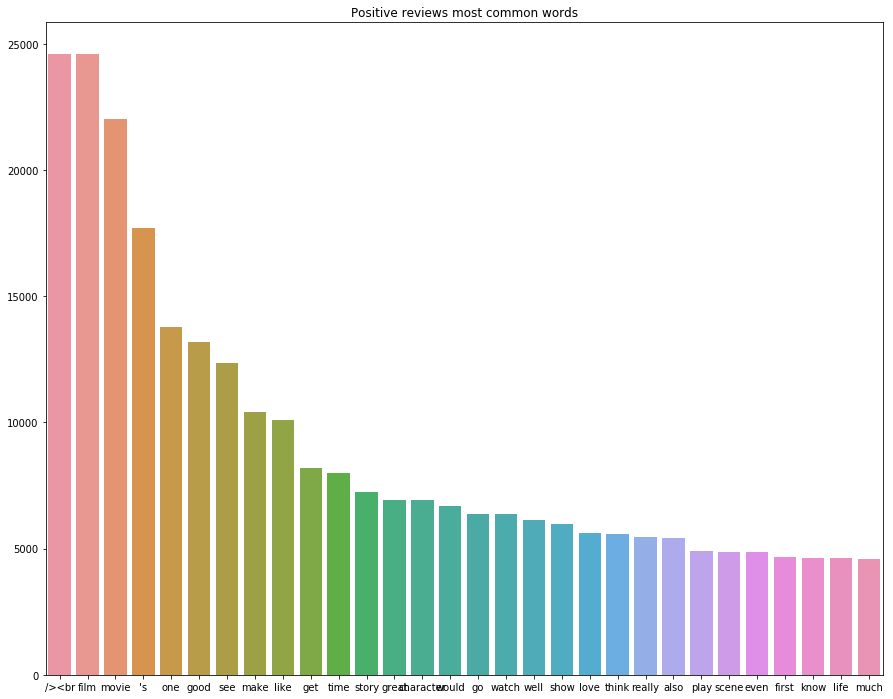

In [10]:
plt.figure(figsize=(15, 12))

sns.barplot(x=positive_common_words, y=positive_common_count)
plt.title('Positive reviews most common words')
plt.show()

Вижда се шум от '/><br' и 's', да видим дали има и такъв при негативните ревюта

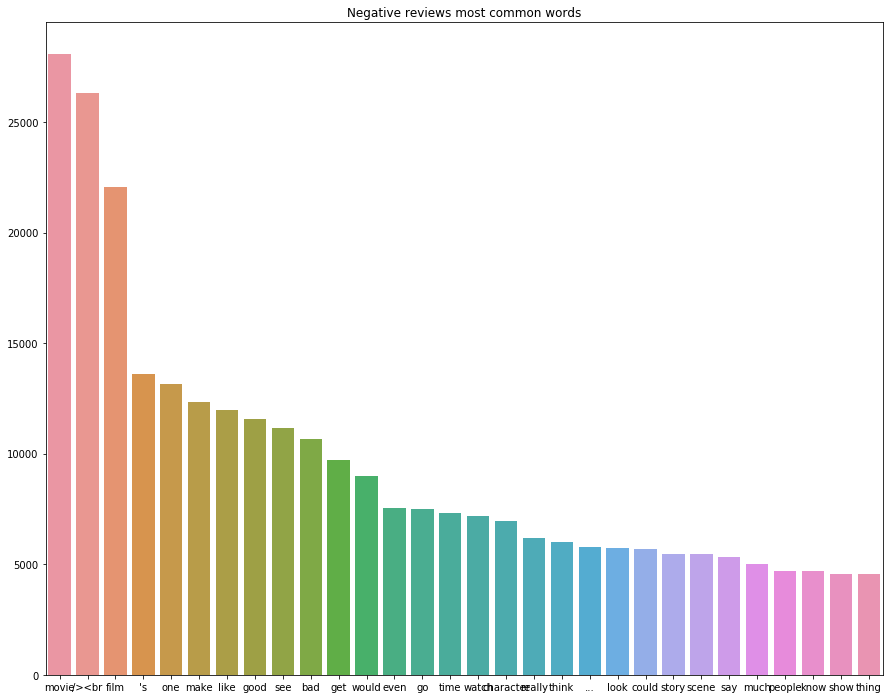

In [11]:
plt.figure(figsize=(15, 12))

sns.barplot(x=negative_common_words, y=negative_common_count)
plt.title('Negative reviews most common words')
plt.show()

Виждаме същотот нещо, даже има още "шум "-  '...'

Да изчистим още малко данните

In [12]:
positive_clean = [word for word in positive_clean if word != '\'s' and word != '/><br' and word != '...']
negative_clean = [word for word in positive_clean if word != '\'s' and word != '/><br' and word != '...']

In [14]:
positive_counts = Counter(positive_clean)
negative_counts = Counter(negative_clean)

positive_common_words = [word[0] for word in positive_counts.most_common(30)]
positive_common_count = [word[1] for word in positive_counts.most_common(30)]

negative_common_words = [word[0] for word in negative_counts.most_common(30)]
negative_common_count = [word[1] for word in negative_counts.most_common(30)]


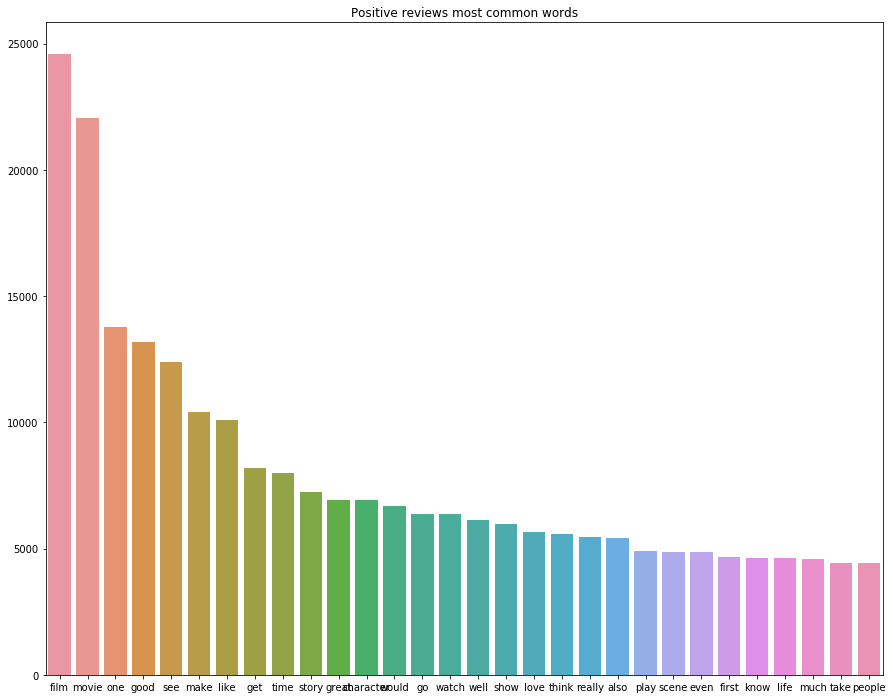

In [15]:
plt.figure(figsize=(15, 12))

sns.barplot(x=positive_common_words, y=positive_common_count)
plt.title('Positive reviews most common words')
plt.show()

<strong>Така е по-добре</strong>

In [16]:
train_cleaned = clean(train['review'], logging=True)
train_cleaned = [word for word in train_cleaned if word != '\'s' and word != '/><br' and word != '...']


Преработени 1000 от 25000 ревюта.
Преработени 2000 от 25000 ревюта.
Преработени 3000 от 25000 ревюта.
Преработени 4000 от 25000 ревюта.
Преработени 5000 от 25000 ревюта.
Преработени 6000 от 25000 ревюта.
Преработени 7000 от 25000 ревюта.
Преработени 8000 от 25000 ревюта.
Преработени 9000 от 25000 ревюта.
Преработени 10000 от 25000 ревюта.
Преработени 11000 от 25000 ревюта.
Преработени 12000 от 25000 ревюта.
Преработени 13000 от 25000 ревюта.
Преработени 14000 от 25000 ревюта.
Преработени 15000 от 25000 ревюта.
Преработени 16000 от 25000 ревюта.
Преработени 17000 от 25000 ревюта.
Преработени 18000 от 25000 ревюта.
Преработени 19000 от 25000 ревюта.
Преработени 20000 от 25000 ревюта.
Преработени 21000 от 25000 ревюта.
Преработени 22000 от 25000 ревюта.
Преработени 23000 от 25000 ревюта.
Преработени 24000 от 25000 ревюта.
Преработени 25000 от 25000 ревюта.


# Сега да видим малко комбинации между векторайзери и модели за класификация, и тяхните резултати

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression


<strong>Първо логистична регресия</strong>

In [23]:
pipeline = Pipeline([
        ('features', CountVectorizer()),
        ('clf', LogisticRegression())
    ])


cross_val_score(pipeline, train.review, train.sentiment, cv=3, n_jobs=3)

array([ 0.88036957,  0.87317015,  0.8768603 ])

<strong>Случайна гора</strong>

In [27]:
pipeline = Pipeline([
        ('features', CountVectorizer()),
        ('clf', RandomForestClassifier())
    ])


cross_val_score(pipeline, train.review, train.sentiment, cv=3, n_jobs=3)

array([ 0.74766019,  0.73530118,  0.73427748])

<strong>TFIDF с Multinomial Naive Bayes<strong>

In [29]:
pipeline = Pipeline([
        ('features', TfidfVectorizer()),
        ('clf', MultinomialNB())
    ])
cross_val_score(pipeline, train.review, train.sentiment, cv=3, n_jobs=3)

array([ 0.8587713 ,  0.86537077,  0.85897744])

<strong>Засега логистичната регресия изглежда победител. Да пробваме друг подход</strong>

# Word2Vec

При <strong>Word2Vec</strong> няма нужда да премахване стоп думи и местоимения, защото те помагат, като дава контекст.

In [30]:
#комбинация на всички данни
all_reviews = np.concatenate((train['review'], test['review']), axis=0)
all_reviews = pd.DataFrame(all_reviews, columns=['review'])
print('Number of total reviews:', len(all_reviews))

Number of total reviews: 50000


In [31]:
def clean_word2vec(docs, logging=False):
    sentences = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Преработени %d от %d текста." % (counter, len(docs)))
        doc = nlp(doc, disable=['tagger'])
        #лематицация на думите() и само с малки букви
        doc = " ".join([tok.lemma_.lower() for tok in doc])
        # разделяне на изреченито, спрямо пунктуацията
        doc = re.split("[\.?!;] ", doc)
        # премахване на препинателните знаци
        doc = [re.sub("[\.,;:!?]", "", sent) for sent in doc]
        # разделяне на думи
        doc = [sent.split() for sent in doc]
        sentences += doc
        counter += 1
    return sentences

In [32]:
train_cleaned_word2vec = clean_word2vec(all_reviews['review'], logging=True)

Преработени 1000 от 50000 текста.
Преработени 2000 от 50000 текста.
Преработени 3000 от 50000 текста.
Преработени 4000 от 50000 текста.
Преработени 5000 от 50000 текста.
Преработени 6000 от 50000 текста.
Преработени 7000 от 50000 текста.
Преработени 8000 от 50000 текста.
Преработени 9000 от 50000 текста.
Преработени 10000 от 50000 текста.
Преработени 11000 от 50000 текста.
Преработени 12000 от 50000 текста.
Преработени 13000 от 50000 текста.
Преработени 14000 от 50000 текста.
Преработени 15000 от 50000 текста.
Преработени 16000 от 50000 текста.
Преработени 17000 от 50000 текста.
Преработени 18000 от 50000 текста.
Преработени 19000 от 50000 текста.
Преработени 20000 от 50000 текста.
Преработени 21000 от 50000 текста.
Преработени 22000 от 50000 текста.
Преработени 23000 от 50000 текста.
Преработени 24000 от 50000 текста.
Преработени 25000 от 50000 текста.
Преработени 26000 от 50000 текста.
Преработени 27000 от 50000 текста.
Преработени 28000 от 50000 текста.
Преработени 29000 от 50000 те

In [145]:
from gensim.models.word2vec import Word2Vec
print("Трениране на Word2Vec модел...")
wordvec_model = Word2Vec(train_cleaned_word2vec, size=50, window=5, min_count=3, workers=4, sg=1)
print("Word2Vec моделът е създаден.")


Трениране на Word2Vec модел...
Word2Vec моделът е създаден.


In [146]:
# Създаване на вектори
def create_average_vec(doc):
    average = np.zeros((50,), dtype='float32')
    num_words = 0.
    for word in doc.split():
        if word in wordvec_model.wv.vocab:
            average = np.add(average, wordvec_model[word])
            num_words += 1.
    if num_words != 0.:
        average = np.divide(average, num_words)
    return average

In [147]:
# Създаване на вектори
train_cleaned_vec = np.zeros((train.shape[0], 50), dtype="float32")
for i in range(len(train_cleaned)):
    train_cleaned_vec[i] = create_average_vec(train_cleaned[i])


In [148]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_cleaned_vec, train['sentiment'], test_size=0.2, random_state=21)

print('X_train size: {}'.format(X_train.shape))
print('X_test size: {}'.format(X_test.shape))
print('y_train size: {}'.format(y_train.shape))
print('y_test size: {}'.format(y_test.shape))

X_train size: (20000, 50)
X_test size: (5000, 50)
y_train size: (20000,)
y_test size: (5000,)


In [149]:
y_train[:10]

id
2873_1     0
6933_9     1
10616_2    0
6287_4     0
6711_10    1
7821_1     0
5465_1     0
3914_2     0
11267_1    0
7979_1     0
Name: sentiment, dtype: int64

In [154]:
def initiate(architecture='mlp'):
    model = Sequential()
    model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_dim=50))
    model.add(Dropout(0.1))
    model.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.1))
    model.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='softmax'))
    return model

In [155]:
model = initiate('mlp')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 10)                510       
_________________________________________________________________
dropout_45 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_46 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_47 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_56 (Dense)             (None, 10)                110       
__________

In [156]:
# Компилиране на модела с оптимизатор sgd, пробвах с Adagrad и Adam
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='mean_squared_error', metrics=['acc'])

In [157]:
epochs = 10

estimator = model.fit(X_train, y_train,
                      validation_split=0.2,
                      epochs=epochs, batch_size=128, verbose=2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
 - 1s - loss: 0.5017 - acc: 0.4983 - val_loss: 0.4935 - val_acc: 0.5065
Epoch 2/10
 - 0s - loss: 0.5017 - acc: 0.4983 - val_loss: 0.4935 - val_acc: 0.5065
Epoch 3/10
 - 0s - loss: 0.5017 - acc: 0.4983 - val_loss: 0.4935 - val_acc: 0.5065
Epoch 4/10
 - 0s - loss: 0.5017 - acc: 0.4983 - val_loss: 0.4935 - val_acc: 0.5065
Epoch 5/10
 - 0s - loss: 0.5017 - acc: 0.4983 - val_loss: 0.4935 - val_acc: 0.5065
Epoch 6/10
 - 0s - loss: 0.5017 - acc: 0.4983 - val_loss: 0.4935 - val_acc: 0.5065
Epoch 7/10
 - 0s - loss: 0.5017 - acc: 0.4983 - val_loss: 0.4935 - val_acc: 0.5065
Epoch 8/10
 - 0s - loss: 0.5017 - acc: 0.4983 - val_loss: 0.4935 - val_acc: 0.5065
Epoch 9/10
 - 0s - loss: 0.5017 - acc: 0.4983 - val_loss: 0.4935 - val_acc: 0.5065
Epoch 10/10
 - 0s - loss: 0.5017 - acc: 0.4983 - val_loss: 0.4935 - val_acc: 0.5065


In [158]:
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % 
      (100*estimator.history['acc'][-1], 100*estimator.history['val_acc'][-1]))

Training accuracy: 49.83% / Validation accuracy: 50.65%


In [159]:
forest = RandomForestClassifier( n_estimators = 100 )
forest = forest.fit( X_train, y_train)

In [160]:
forest.score(X_test,y_test)

0.81699999999999995

In [161]:
model = LogisticRegression()
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.83699999999999997

# Най-добри резултати се получиха с логистична регресия и "торба с думи", пробвах доста варианти за невронната мрежа(оптимизатори, лос функции и аквивации), но без успех

# По-добро разучаване на keras и какви данни да се подават от Word2Vec във формата на вектор